# Analysis of TV Show Data

## Setup

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

In [3]:
!conda list '(matplotlib|seaborn|python\Z|scipy|pandas)'

# packages in environment at /Users/rcharan/anaconda3/envs/yelpapi:
#
# Name                    Version                   Build  Channel
ipython                   7.9.0            py37h5ca1d4c_0    conda-forge
matplotlib                3.1.1                    py37_1    conda-forge
matplotlib-base           3.1.1            py37h3a684a6_1    conda-forge
mysql-connector-python    8.0.17           py37h7d2c6da_0    conda-forge
pandas                    0.25.2           py37h4f17bb1_0    conda-forge
python                    3.7.3                h93065d6_1    conda-forge
scipy                     1.3.1            py37h7e0e109_2    conda-forge
seaborn                   0.9.0                      py_1    conda-forge


```python
# Name                    Version                   Build  Channel
ipython                   7.9.0            py37h5ca1d4c_0    conda-forge
matplotlib                3.1.1                    py37_1    conda-forge
matplotlib-base           3.1.1            py37h3a684a6_1    conda-forge
mysql-connector-python    8.0.17           py37h7d2c6da_0    conda-forge
pandas                    0.25.2           py37h4f17bb1_0    conda-forge
python                    3.7.3                h93065d6_1    conda-forge
scipy                     1.3.1            py37h7e0e109_2    conda-forge
seaborn                   0.9.0                      py_1    conda-forge
```

In [4]:
%matplotlib inline

In [5]:
pd.set_option('display.max_columns', 100)

sns.set_context('talk')
sns.set_style('darkgrid', {'patch.edgecolor' : 'none', 'patch.force_edgecolor' : False})

## Import Data

Produces Tables:
  - streaming (RT data for each streaming show)
  - nielsen   (Nielsen and RT data for each *episode* of a corded TV show)
  - avged     (Nielsen and RT data for each corded TV show)
  - together  (streaming and avged concatenated)

In [6]:
from db import *
nielsen   = query('SELECT * FROM nielsen')
streaming = query('SELECT * FROM streaming')

In [7]:
avged = \
nielsen.groupby('rt_id').agg({
     'rt_id'               : 'first'
    ,'title'               : 'first'
    ,'critic_rating'       : 'first'
    ,'audience_rating'     : 'first'
    ,'network'             : 'first'
    ,'genre'               : 'first'
    ,'executive_producers' : 'first'
    ,'demo_rating'         : 'mean'
})

In [8]:
keep_fields = ['rt_id', 'title', 'critic_rating', 'audience_rating', 'genre', 'network', 'executive_producers']
together = pd.concat([avged[keep_fields], streaming[keep_fields]], axis = 0)

grouper = lambda n : n if n in ['Netflix', 'Amazon'] else 'Cord TV'

together['network_grouped'] = together.network.map(grouper)

# Analysis

# Slide 1 - Money plot

In [9]:
temp_df = avged[['critic_rating', 'audience_rating', 'demo_rating']]
temp_df = temp_df.reset_index().rename({'rt_id'           : 'show',
                                        'critic_rating'   : 'rt_critic',
                                        'audience_rating' : 'rt_audience', 'demo_rating' : 'nielsen'},
                                       axis = 'columns')
temp_df = pd.wide_to_long(temp_df, 'rt', i = 'show', j = 'rating_type', sep = '_', suffix = '.*')
temp_df = temp_df.reset_index()

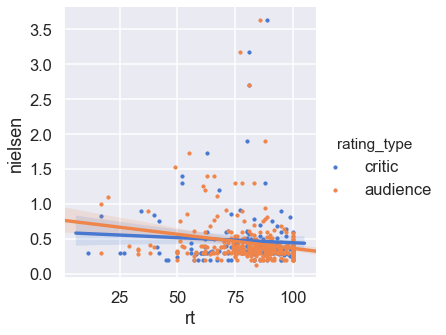

In [10]:
# fig, ax = plt.subplots()
g = sns.lmplot(x = 'rt', y = 'nielsen', hue = 'rating_type', 
           data = temp_df,
           palette = 'muted',
           scatter_kws={"s": 10, "alpha": 1})
g.savefig('critical_reception.svg')

In [11]:
lm_critic = sm.ols(formula = 'demo_rating ~ critic_rating', data = avged).fit()
lm_critic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            demo_rating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5875
Date:                Fri, 01 Nov 2019   Prob (F-statistic):              0.444
Time:                        10:21:22   Log-Likelihood:                -103.15
No. Observations:                 171   AIC:                             210.3
Df Residuals:                     169   BIC:                             216.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5912      0.157      3.770      0.000       0.282       0.901
critic_rating    -0.0015      0.002     -0.766      0.444      -0.005       0.002
==============================================================================
Omnibus:                      197.703   Durbin-Watson:                   1.738
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5232.464
Skew:                           4.659   Prob(JB):                         0.00
Kurtosis:                      28.447   Cond. No.                         379.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
lm_audience = sm.ols(formula = 'demo_rating ~ audience_rating', data = avged).fit()
lm_audience.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            demo_rating   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     11.45
Date:                Fri, 01 Nov 2019   Prob (F-statistic):           0.000800
Time:                        10:21:22   Log-Likelihood:                -120.38
No. Observations:                 333   AIC:                             244.8
Df Residuals:                     331   BIC:                             252.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.7671      0.100      7.708      0.000       0.571       0.963
audience_rating    -0.0040      0.001     -3.384      0.001      -0.006      -0.002
==============================================================================
Omnibus:                      390.842   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21292.869
Skew:                           5.324   Prob(JB):                         0.00
Kurtosis:                      40.699   Cond. No.                         437.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
lm_critic = sm.ols(formula = 'demo_rating ~ audience_rating + critic_rating', data = avged).fit()
lm_critic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            demo_rating   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.548
Date:                Fri, 01 Nov 2019   Prob (F-statistic):              0.216
Time:                        10:21:22   Log-Likelihood:                -100.66
No. Observations:                 165   AIC:                             207.3
Df Residuals:                     162   BIC:                             216.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.9073      0.248      3.660      0.000       0.418       1.397
audience_rating    -0.0053      0.004     -1.458      0.147      -0.012       0.002
critic_rating    1.598e-05      0.002      0.007      0.995      -0.005       0.005
==============================================================================
Omnibus:                      191.723   Durbin-Watson:                   1.766
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5020.385
Skew:                           4.644   Prob(JB):                         0.00
Kurtosis:                      28.377   Cond. No.                         820.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Slide 2 — Prepare for Seasonality
This could either be
1. A sign of when people watch TV
1. A sign of when the networks are the strongest competition

If the former, great. If the latter, there could be unmet demand

RT ratings versus premiere date by network
Demo_ratings versus month

In [14]:
by_month = nielsen.copy()
by_month.dropna(subset = ['date'], inplace = True)
by_month['month'] = by_month.date.dt.month

In [15]:
%%capture
fig, ax = plt.subplots()
sns.set_color_codes("pastel")
sns.barplot(x = 'month', y = 'demo_rating', data = by_month, ax = ax, color = 'b', errwidth = 2);
ax.set_title('Average Viewership by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Viewership\n(Nielsen Rating 18-49)')

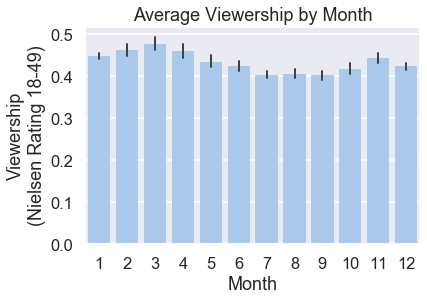

In [16]:
fig

In [17]:
fig.savefig('viewership_by_month.svg')

In [18]:
vals =  by_month.groupby(['month'])['demo_rating'].mean()

In [19]:
vals.round(2).tolist()

[0.45, 0.46, 0.48, 0.46, 0.44, 0.42, 0.4, 0.41, 0.4, 0.42, 0.44, 0.42]

# Slide 2

In [20]:
%%capture
temp_df = together[['rt_id', 'network_grouped', 'audience_rating', 'critic_rating']].rename({'network_grouped' : 'network'}, axis = 'columns').set_index(['rt_id', 'network']).stack()
temp_df.index.set_names('rating_type', 2, inplace = True)
temp_df = temp_df.rename('rating').reset_index()
fig, ax = plt.subplots()
sns.barplot(x = 'network', y = 'rating', hue = 'rating_type', data = temp_df, ax = ax)
ax.set_title('Audience and Critic Scores by Service')
ax.set_xlabel('Service')
ax.set_ylabel('Rotten Tomatoes\nScore (0-100)')

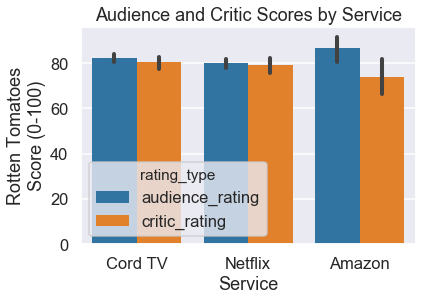

In [21]:
fig

In [22]:
fig.savefig('rt_score_by_service.svg')

In [23]:
temp_df.groupby(['network', 'rating_type']).mean().round(0)

rating
network rating_type            
Amazon  audience_rating    87.0
        critic_rating      74.0
Cord TV audience_rating    82.0
        critic_rating      80.0
Netflix audience_rating    80.0
        critic_rating      79.0

In [24]:
temp_df.groupby(['network', 'rating_type']).mean().round(0)['rating'].tolist()

[87.0, 74.0, 82.0, 80.0, 80.0, 79.0]